In [5]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
# from topoPy import *

In [6]:
def readnc(datfile,var):
    #---- topography data file
    df = nc.Dataset(datfile)
    # print(df.variables)
    
    #---- variable and coordinates
    lon, lat = df.variables['lon'][:], df.variables['lat'][:]
    z = df.variables[var['name']][:]
    df.close()
    
    return lon, lat, z

def fetch_vwdata_by_idx(datfile,var,lon_centre,lat_centre,lon_vert,lat_vert,links):
    
    #---- variable and the coordinates
    lon, lat, z = readnc(datfile, var)
    
    #---- get number of records,nlat,nlon
    nrecords = np.shape(z)[0]; nlon = np.shape(lon)[1]; nlat = np.shape(lat)[1]
    
    #---- process each record to get the (lon,lat) for each topographic observation in 1D
    lon_res=[]; lat_res=[]; z_res=[]   # resulting lon,lat,z  
    
    for n in links:
        # print('n = ',n)
        lon_,lat_ = np.meshgrid(lon[n][:],lat[n][:])
#         print(lon_, lat_)
        lon_= lon_.ravel() 
        lat_ = lat_.ravel() 
        z_ = np.flipud(z[n][:])
        
        # print(z_[5])
        z_ = z_.ravel()
#         print(lon_.shape, lat_.shape, z_.shape)
        cond_lat = ( lat_vert.min() <= lat_ ) & ( lat_ <= lat_vert.max() )
        cond_lon = ( lon_vert.min() <= lon_ ) & ( lon_ <= lon_vert.max() )
        idx = np.nonzero((cond_lat & cond_lon))[0]

        # idx = np.nonzero((np.abs(lon_ - lon_centre)<= lon_width/2) & 
                         # (np.abs(lat_ - lat_centre)<= lat_width/2))[0]
        # print(idx)
        if len(idx)!=0:
            lon_dummy,lat_dummy,z_dummy = lon_[idx],lat_[idx],z_[idx]
            lon_res.extend(lon_dummy.tolist())
            lat_res.extend(lat_dummy.tolist())
            z_res.extend(z_dummy.tolist())
    
    lon_res = np.array(lon_res)
    lat_res = np.array(lat_res)
    z_res = np.array(z_res)
        
    # print(z_res[300:350])
    
    del lat, lon, z
        
    #---- processing of the lat,lon,topo to get the regular 2D grid for topography
    lon_uniq, lat_uniq = np.unique(lon_res), np.unique(lat_res) # get unique values of lon,lat
    nla = len(lat_uniq); nlo = len(lon_uniq)
    
    # print("lat_res shape = ", lat_res.shape)
    # print("lon_res shape = ", lon_res.shape)
    # print("z_res shape = ", z_res.shape)
    # print("nla = ", nla)
    # print("nlo = ", nlo)

    #---- building 2D topography field
    lat_lon_topo = np.vstack((lat_res,lon_res,z_res)).T
    lat_lon_topo = lat_lon_topo[lat_lon_topo[:,0].argsort()]  # sorted according to latitude
    lon_sort_id = [lat_lon_topo[n*nlo:(n+1)*nlo,1].argsort()+nlo*n for n in range(nla)] 
    lon_sort_id = np.array(lon_sort_id).reshape(-1)
    lat_lon_topo = lat_lon_topo[lon_sort_id]  # sorted according to longitude for each len(lon_u)
    topo_2D = np.reshape(lat_lon_topo[:,2],(nla,nlo))
    
    del lat_lon_topo, lon_sort_id
        
    # print('Data fetched...')
    return lon_uniq, lat_uniq, topo_2D

[[3 0 0 0 0 0]
 [2 0 0 0 0 0]
 [2 5 0 0 0 0]
 [2 0 0 0 0 0]
 [1 0 0 0 0 0]
 [4 6 0 0 0 0]]
CPU times: user 97.4 ms, sys: 190 ms, total: 287 ms
Wall time: 302 ms


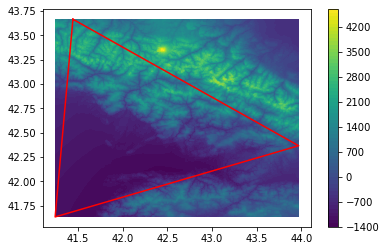

CPU times: user 120 ms, sys: 117 ms, total: 238 ms
Wall time: 235 ms


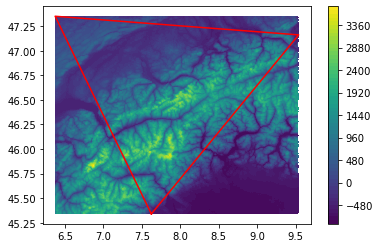

CPU times: user 155 ms, sys: 415 ms, total: 570 ms
Wall time: 577 ms


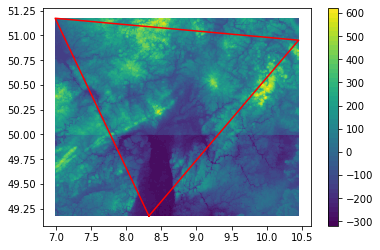

CPU times: user 118 ms, sys: 207 ms, total: 325 ms
Wall time: 327 ms


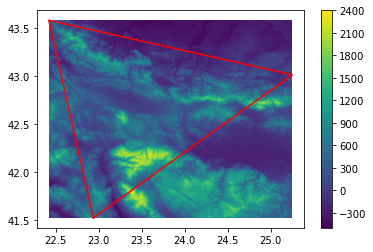

CPU times: user 89 ms, sys: 165 ms, total: 254 ms
Wall time: 256 ms


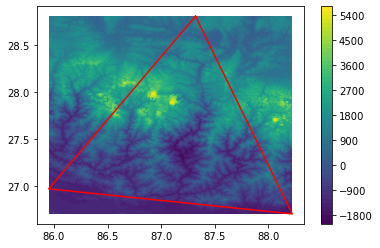

CPU times: user 186 ms, sys: 266 ms, total: 452 ms
Wall time: 454 ms


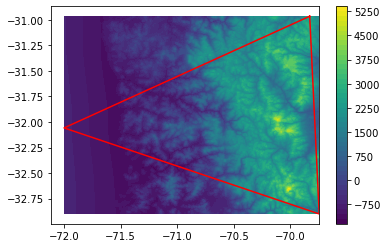

In [7]:
sfx = '6'

df = nc.Dataset('../data/icon_compact_linked_%s.nc' %sfx)

clat = df.variables['clat'][:]
clon = df.variables['clon'][:]
clat_vertices = df.variables['clat_vertices'][:]
clon_vertices = df.variables['clon_vertices'][:]
links = df.variables['links'][:]

df.close()

print(links)

clat = clat*(180/np.pi)
clon = clon*(180/np.pi)

clat_vertices = clat_vertices*(180/np.pi)
clon_vertices = clon_vertices*(180/np.pi)

datfile = '../data/topo_compact_%s.nc' %sfx
var = {'name':'topo','units':'m'}

# lon, lat, z = readnc(datfile, var)
# nrecords = np.shape(z)[0]; nlon = np.shape(lon)[1]; nlat = np.shape(lat)[1]

df_out = nc.Dataset('../data/output_%s.nc' %sfx)

nouts = clat.shape[0]
# nouts = 90

for vid in range(0,nouts):
    lat_centre = clat[vid]
    lon_centre = clon[vid]
    lat_vert = clat_vertices[vid,:]
    lon_vert = clon_vertices[vid,:]
    
    nonzero_links = links[vid,:]
    nonzero_links = nonzero_links[nonzero_links > 0]

#     # ---- get the topography around the cell picked

    %time lon,lat,z = fetch_vwdata_by_idx(datfile,var,lon_centre,lat_centre,lon_vert,lat_vert,nonzero_links-1)
    
    # print(z[0][300:350])
    
    i = vid+1
    name = "topo_%i" %i
    lat_name = "lat_grid_%i" %i
    lon_name = "lon_grid_%i" %i
    
    data = df_out.variables[name][:]
    lat_grid = df_out.variables[lat_name][:]
    lon_grid = df_out.variables[lon_name][:]
    
    # print(data)

    # print(lat-lat_grid[:,0])
    # print(lon-lon_grid[0,:])
    
    plt.contourf(lon,lat,z,60)
    x = np.append(clon_vertices[vid,:],clon_vertices[vid,0])
    y = np.append(clat_vertices[vid,:],clat_vertices[vid,0])
    plt.plot(x,y,'-r')
    plt.colorbar()
    plt.show()

(244, 327)


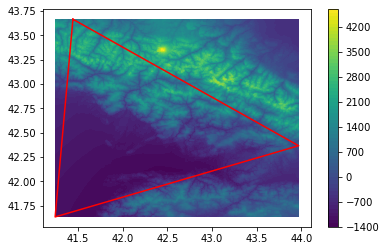

(241, 379)


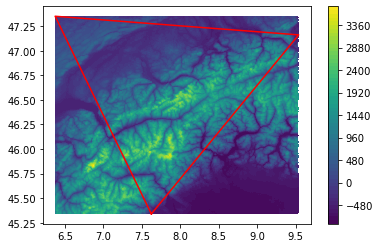

(240, 415)


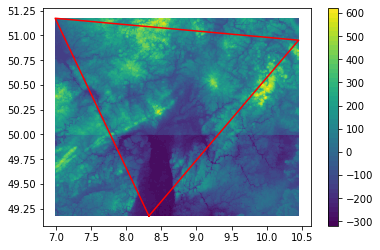

(248, 340)


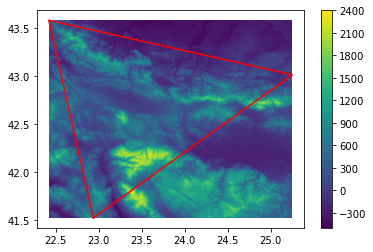

(252, 273)


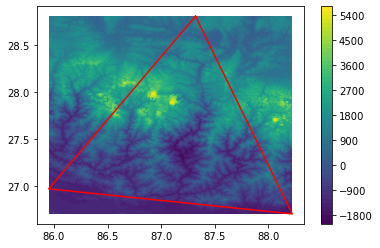

(232, 271)


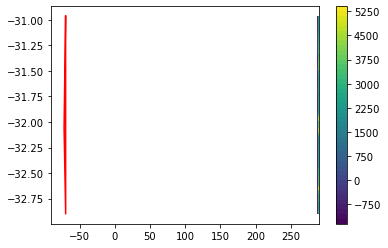

In [59]:
sfx = '6'
df = nc.Dataset('../data/output_%s.nc' %sfx)

for i in range(1,nouts+1):
    name = "topo_%i" %i
    lat_name = "lat_grid_%i" %i
    lon_name = "lon_grid_%i" %i
    
    data = df.variables[name][:]
    lat_grid = df.variables[lat_name][:]
    lon_grid = df.variables[lon_name][:]
    
    print(data.shape)

    plt.contourf(lon_grid, lat_grid, data, 60)
    
    vid = i-1
    x = np.append(clon_vertices[vid,:],clon_vertices[vid,0])
    y = np.append(clat_vertices[vid,:],clat_vertices[vid,0])
    plt.plot(x,y,'-r')
    plt.colorbar()
    plt.show()

df.close()

In [9]:
def rad_to_deg(val):
    return val * 180.0 / np.pi

vx = np.array([-2.8907089284406324, 0.6283185307179578, 1.8849555921538772])
vx = np.array([0.24288209097473423, 8.655095639727097E-15, 1.256637061435913])

vx = rad_to_deg(vx)

vy = np.array([1.5707963267948946, 1.5396079515651673, 1.5396079515651668])
# vy = np.array([1.5707963267948948	1.5396079515651657	1.5396079515651668]
vy = rad_to_deg(vy)
print(vy)
print(vx)


def tri_area(x,y):
    Ax,Bx,Cx = vx[0], vx[1], vx[2]
    Ay,By,Cy = vy[0], vy[1], vy[2]
    
    return Ax * (By - Cy) + Bx * (Cy - Ay) + Cx * (Ay - By)

print(tri_area(vx,vy))

[90.         88.21303773 88.21303773]
[1.39161187e+01 4.95900451e-13 7.20000000e+01]
128.66128347842903


1 0.0 1340.77099609375


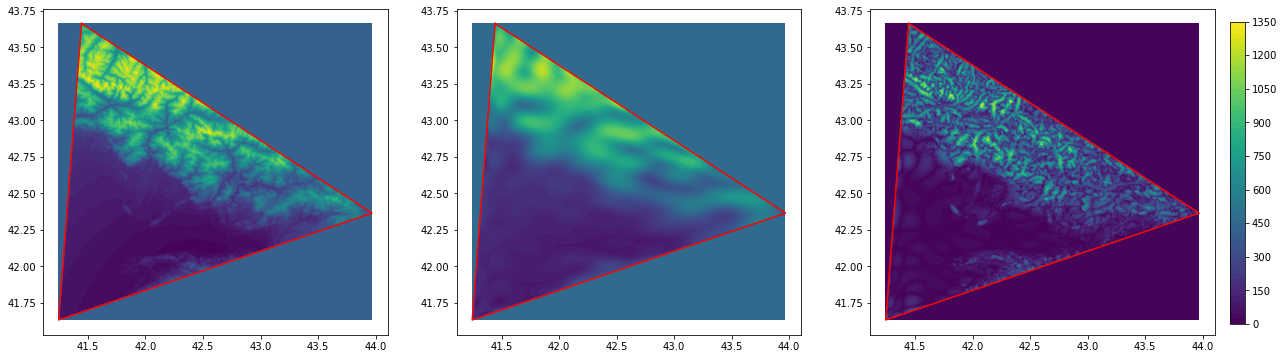


2 0.0 1667.3900146484375


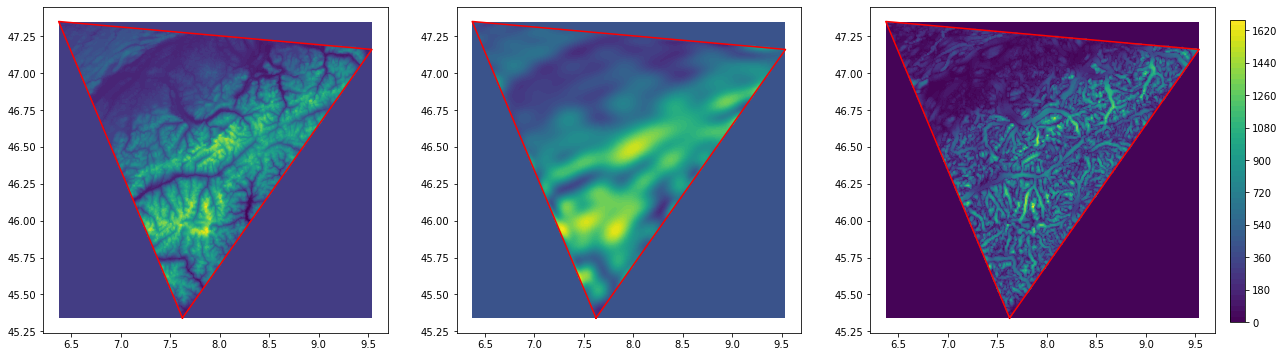


3 0.0 345.7538757324219


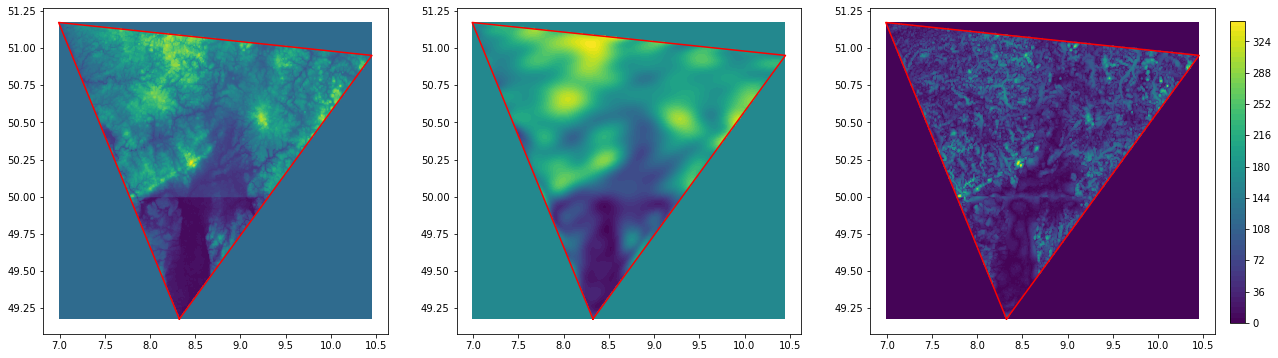


4 0.0 855.9298706054688


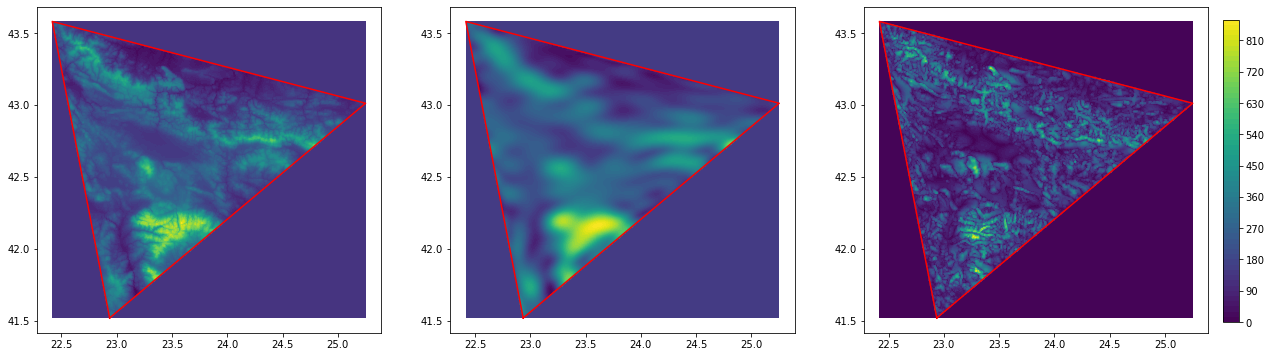


5 0.0 2267.1962890625


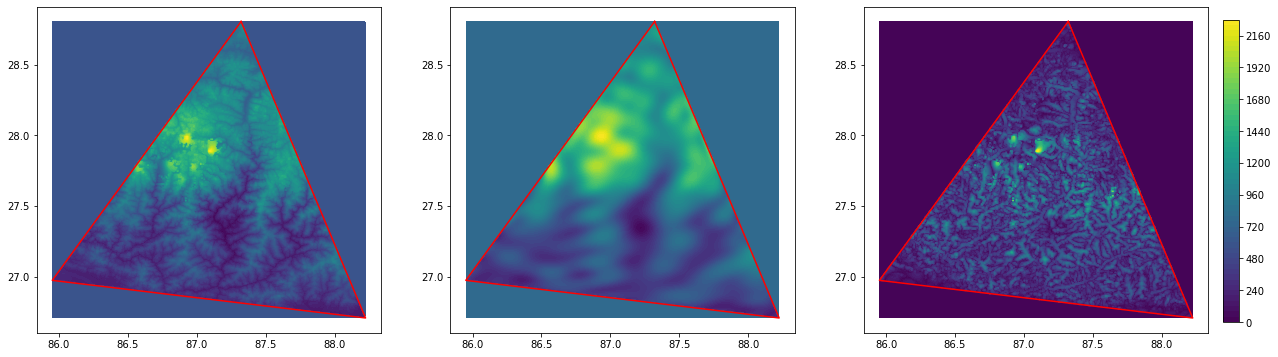


6 0.0 1872.366943359375


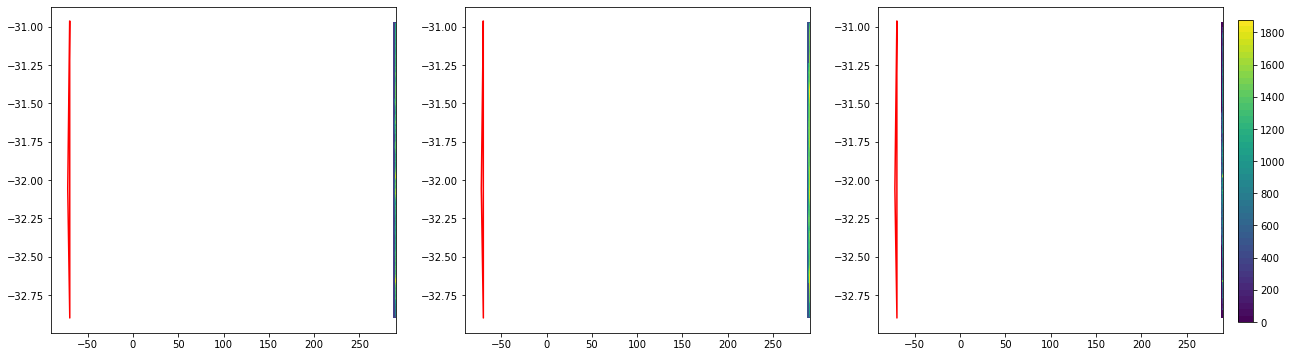

In [61]:
sfx = '6'
df = nc.Dataset('../data/output_%s.nc' %sfx)

for i in range(1,7):
    name = "topo_%i" %i
    lat_name = "lat_grid_%i" %i
    lon_name = "lon_grid_%i" %i
    recon_name = "topo_recon_%i" %i
    mask_name = "mask_%i" %i
    
    data = df.variables[name][:]
    lat_grid = df.variables[lat_name][:]
    lon_grid = df.variables[lon_name][:]
    topo_grid = df.variables[recon_name][:]
    mask = df.variables[mask_name][:]
    
#     print(i, data_masked.min(), data_masked.max())
#     print(i, topo_grid.min(), topo_grid.max())
    
    data_masked = data*mask
    # fig = plt.figure()
    # gs = fig.add_gridspec(1, 2, hspace=0, wspace=0.1)
    # (ax1, ax2) = gs.subplots()
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 6))
    im1 = ax1.contourf(lon_grid, lat_grid, data_masked, 60)
    vid = i-1
    x = np.append(clon_vertices[vid,:],clon_vertices[vid,0])
    y = np.append(clat_vertices[vid,:],clat_vertices[vid,0])
    ax1.plot(x,y,'-r')
    
    im2 = ax2.contourf(lon_grid, lat_grid, topo_grid, 60)
    ax2.plot(x,y,'-r')
    # cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
    # fig.colorbar(im2, cax=cbar_ax)
    
    diff_topo = np.abs(data_masked-topo_grid)
    print(i, diff_topo.min(), diff_topo.max())
    im3 = ax3.contourf(lon_grid, lat_grid, diff_topo, 60)
    ax3.plot(x,y,'-r')
    cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
    fig.colorbar(im3, cax=cbar_ax)
    plt.show()
    
    print("")

df.close()

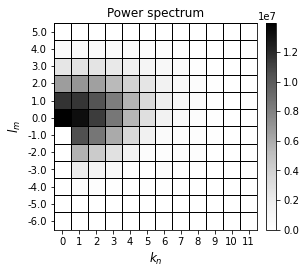

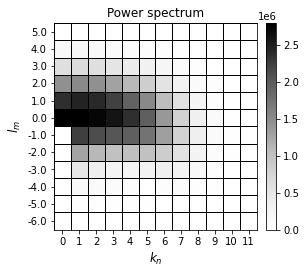

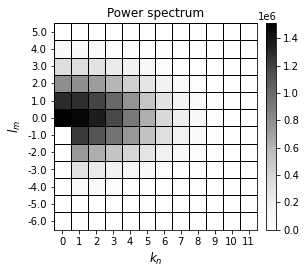

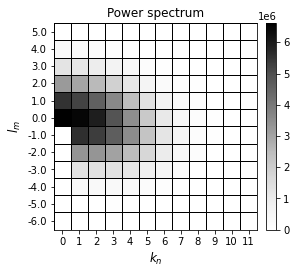

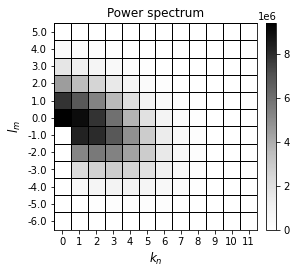

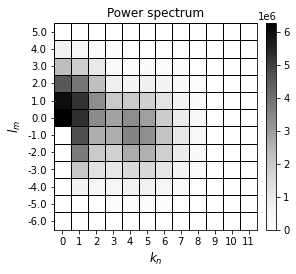

In [63]:
sfx = '6'
df = nc.Dataset('../data/output_%s.nc' %sfx)

re_name = "re_fcoeffs"
im_name = "im_fcoeffs"

real = df.variables[re_name][:]
imag = df.variables[im_name][:]

wlat = df.variables['wavelength_lat'][:]
wlon = df.variables['wavelength_lon'][:]

for i in range(0,nouts):

    idx = i
    
    fcoeffs = real[idx] + 1.0j * imag[idx]
    
    fs = (4,3.8)
    plt.figure(figsize=fs)

    im = plt.pcolormesh(np.abs(fcoeffs), edgecolors='k', cmap='Greys')
    plt.colorbar(im,fraction=0.05, pad=0.04)
    nhar_j = 12
    if nhar_j % 2 == 0:
        m_j = np.arange(-nhar_j/2,nhar_j/2)
    else:
        m_j = np.arange(-(nhar_j-1)/2,(nhar_j)/2)

    ylocs = np.arange(.5,12.5,1.0)
    plt.yticks(ylocs, m_j)
    plt.xticks(ylocs, np.arange(0,12))
    plt.title("Power spectrum")
    plt.xlabel(r'$k_n$', fontsize=12)
    plt.ylabel(r'$l_m$', fontsize=12)
    # plt.grid()
    # plt.savefig('axial_coeffs_rot.pdf', bbox_inches='tight')
    plt.show()

df.close()

In [83]:
AE = 6371.0008 * 1E3 # Earth's radius in [m]

re = real[0]
im = imag[0]
wla = wlat[0] * AE
wlo = wlon[0] * AE

hhg = re + 1.0j * im

# print(hhg)

N = 0.02 # s^{-1}
U = 10.0 # m s^{-1}
V = 10.0 # m s^{-1}

kk = np.arange(0,12) / wlo
ll = np.arange(-6,6) / wla

# print(kk, ll)
kkg, llg = np.meshgrid(kk,ll)

# print(kkg**2 + llg**2)

omg_grid_sq = (- kkg * U - llg * V)**2
# print(omg_grid_sq)

Ag = 0.5 * ( hhg * np.conj(hhg) * N**2 / np.sqrt(omg_grid_sq) ) * 1e-12
Ag = np.real(Ag)
print(Ag)
Agrid = Ag.sum()
print(Agrid)

mmg = np.sqrt((N**2 * (kkg**2 + llg**2) / omg_grid_sq) - (kkg**2 + llg**2))
# print(mmg)

[[0.0 5.1548085300155075e-08 1.543481977579273e-06 1.3229254155608682e-05
  5.7167151111596655e-05 0.00016232494296409357 -- 5.6505271234674025e-05
  7.797765965057735e-06 8.523566113481025e-07 5.701310678143241e-08
  2.0894635212504236e-09]
 [0.0 0.00036972358862974805 0.00020563944044346772 0.0004969475760852963
  0.00299203416277736 -- 0.004431304710885064 0.0010542484179243887
  0.00018540666053645989 1.977835796342385e-05 1.069378781750933e-06
  1.993029028725991e-08]
 [0.0 0.06230668942525284 0.03718718016576248 0.019379132124785294 --
  0.03563438914776281 0.01949495975090082 0.0068812842395084735
  0.0013722560618328922 0.00014065184662921592 6.201410122381218e-06
  7.219868820916534e-08]
 [0.0 2.218690026377986 2.1995455092757794 -- 0.09376474613440249
  0.02269368742278239 0.038271523420558146 0.020649735243440284
  0.004979826415494206 0.0005412421545888813 2.2401212121465088e-05
  2.0668304698308609e-07]
 [0.0 35.24825604086266 -- 8.657324699051944 1.0638836988036737
  0.03

/tmp/ipykernel_232838/1891504834.py:33: RuntimeWarning: divide by zero encountered in true_divide
  mmg = np.sqrt((N**2 * (kkg**2 + llg**2) / omg_grid_sq) - (kkg**2 + llg**2))
/tmp/ipykernel_232838/1891504834.py:33: RuntimeWarning: invalid value encountered in true_divide
  mmg = np.sqrt((N**2 * (kkg**2 + llg**2) / omg_grid_sq) - (kkg**2 + llg**2))
